# CHAPITRE III - Classification de fils de presse : un exemple de classification à plusieurs classes

Après la classification binaire avec le jeux de données IMDB, l'objectif ici est une classification multiclasse de file de presse en fonction des sujets

- Au total 46 classes (sujets) sont présentes dans le jeux de données
- Le jeux de données n'est pas équilibrés mais avec un minimum de 10 observations par classes


## Ouverture des données et présentation rapide

In [2]:
from keras.datasets import reuters

(train_data,train_labels),(test_data,test_labels) = reuters.load_data(num_words=10000)

C:\Users\marec\miniconda3\envs\deeplwithpython\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\marec\miniconda3\envs\deeplwithpython\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
print("les données d'entrainements sont de la forme {} et de dimension {}\nles données d'entrainement sont de la forme {} et de dimension {} "\
      .format(train_data.shape,train_data.ndim,test_data.shape,test_data.ndim))

# classes
set(train_labels)

# nombre d'observation par classe
dic = dict()
for i in train_labels:
    if i not in dic:
        dic[i] = 1
    else:
        dic[i] +=1
        

les données d'entrainements sont de la forme (8982,) et de dimension 1
les données d'entrainement sont de la forme (2246,) et de dimension 1 


Le jeux de données est donc de taille plutot moyenne au vue du nombre de classe à traiter. Comme précédemment les mots sont encodés sous forme d'integer et on peut les récupérer via un dictionnaire avec ```get_word_index()```, méthode associée à la classe ```reuters```. On va aussi recréer la fonction ```reverse_word_index()``` qui à chaque code associe son mot.

In [15]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(v,k) for (k,v) in reuters.get_word_index().items()])

" ".join([reverse_word_index.get(i-3,"?") for i in train_data[150]])

'? the senate passed a two year extension of federal housing programs including 15 billion dlrs for lower income housing assistance over two years the vote was 71 to 27 total value of the bill was estimated at 31 billion dlrs the bill permanently extended the authorization for federal housing authority mortgage ? the bill also extended the urban development grant program the national flood insurance act the rural housing program as well as several other housing programs the bill now goes to the house reuter 3'

## Préparation des données

- transformation en vecteur (tenseur numpy) => création de la fonction ```vectorize_sequence()```
- encodage en fréquence 
- transformation des étiquettes en float

In [42]:
import numpy as np

def vectorize_sequence(sequences,dimension=10000):
    """prend en entrée une liste de sequences contenant des integer représentant des mots unique, de dimension (nombre de mots unique) dimension et retourne la même matrice en binaire en format numpy2D.array"""
    results = np.zeros((len(sequences),dimension))
    for i,sequence in enumerate(sequences):
        results[i,sequence] = 1
    return results

def to_one_hot(labels,dimension=46):
    results = np.zeros((len(labels),dimension))
    for i, label in enumerate(labels):
        results[i,label] = 1
    return(results)

# la fonction to_one_hot est codé dans keras dans utils.np_utils:
from keras.utils.np_utils import to_categorical
to_categorical(train_labels[:10])

<ipython-input-42-ce9870d95012>:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  to_categorical(train_labels[:10]) == to_one_hot(train_labels[:10])


False

In [44]:
x_train = vectorize_sequence(train_data,dimension=10000)
x_test = vectorize_sequence(test_data,dimension=10000)

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)


print(y_train.shape,y_train.dtype)
print(one_hot_train_labels[:4])

# préparation du jeux de données intermédiaire en splittant en train/test le jeux de données train
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

(8982,) float64
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [46]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64,activation="relu",input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

model.compile(optimizer = "rmsprop",
              loss = "categorical_crossentropy",
              metrics = ["AUC"])

model.fit(partial_x_train,
          partial_y_train,
          epochs = 20,
          batch_size = 512,
          validation_data = (x_val,y_val))

Epoch 1/20
16/16 [==============================] - 1s 78ms/step - loss: 2.6031 - auc: 0.8749 - val_loss: 1.7083 - val_auc: 0.9368
Epoch 2/20
16/16 [==============================] - 1s 70ms/step - loss: 1.4151 - auc: 0.9561 - val_loss: 1.3104 - val_auc: 0.9627
Epoch 3/20
16/16 [==============================] - 1s 72ms/step - loss: 1.0551 - auc: 0.9751 - val_loss: 1.1356 - val_auc: 0.9677
Epoch 4/20
16/16 [==============================] - 1s 72ms/step - loss: 0.8328 - auc: 0.9844 - val_loss: 1.0448 - val_auc: 0.9692
Epoch 5/20
16/16 [==============================] - 1s 72ms/step - loss: 0.6591 - auc: 0.9898 - val_loss: 0.9900 - val_auc: 0.9710
Epoch 6/20
16/16 [==============================] - 1s 72ms/step - loss: 0.5264 - auc: 0.9937 - val_loss: 0.9491 - val_auc: 0.9697
Epoch 7/20
16/16 [==============================] - 1s 80ms/step - loss: 0.4266 - auc: 0.9954 - val_loss: 0.9013 - val_auc: 0.9706
Epoch 8/20
16/16 [==============================] - 1s 81ms/step - loss: 0.3464 - a

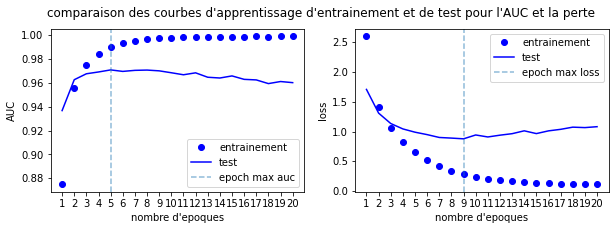

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

# récupération des données à partir de l'historique du modele
history_dic = model.history.history

auc_train = history_dic["auc"]
auc_test = history_dic['val_auc']
loss_train = history_dic['loss']
loss_test = history_dic['val_loss']
epoch = np.arange(1,len(auc_train)+1)


# création de dictionnaire pour récupérer les epoch ou l'auc est max
test_auc_dic = dict(zip(epoch,auc_test))
rev_test_auc_dic = dict([(v,k) for (k,v) in test_auc_dic.items()])
max_auc_test = rev_test_auc_dic.get(max(test_auc_dic.values()))

test_loss_dic = dict(zip(epoch,loss_test))
rev_test_loss_dic = dict([(v,k) for (k,v) in test_loss_dic.items()])
min_loss_test = rev_test_loss_dic.get(min(test_loss_dic.values()))


# figures
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,3))

ax1.plot(epoch,auc_train,marker="o",color="blue",linestyle="none",label="entrainement")
ax1.plot(epoch,auc_test,color="blue",label="test")
ax1.axvline(max_auc_test,linestyle="--",alpha=0.5,label="epoch max auc")
ax1.set_xlabel('nombre d\'epoques')
ax1.set_ylabel('AUC')
ax1.set_xticks(epoch)
ax1.legend()

ax2.plot(epoch,loss_train,marker="o",color="blue",linestyle="none",label="entrainement")
ax2.plot(epoch,loss_test,color="blue",label="test")
ax2.axvline(min_loss_test,linestyle="--",alpha=0.5,label="epoch max loss")
ax2.set_xlabel('nombre d\'epoques')
ax2.set_ylabel('loss')
ax2.set_xticks(epoch)
ax2.legend()


fig.suptitle('comparaison des courbes d\'apprentissage d\'entrainement et de test pour l\'AUC et la perte')


plt.show()

## Modele final: DNN sur les données d'apprentissage avec 9 epochs

On observe un surajustement à partir de l'epoch 9 pour le loss et 5 pour l'AUC. On choisira un nouveau modele se basant sur 9 epochs cette fois ci
Se nouveau modele sera entrainé sur l'ensemble des données d'entrainement pour obtenir notre modele final que nous testerons sur notre vrai ensemble test cette fois !

In [121]:
model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

model.compile(optimizer = "rmsprop",
             loss = "categorical_crossentropy",
             metrics = ["AUC"])

model.fit(x_train,
         one_hot_train_labels,
         epochs = 9,
         batch_size = 512,
         validation_data = (x_test,one_hot_test_labels))

Epoch 1/9
18/18 [==============================] - 2s 93ms/step - loss: 2.4001 - auc: 0.8903 - val_loss: 1.6159 - val_auc: 0.9370
Epoch 2/9
18/18 [==============================] - 1s 82ms/step - loss: 1.2962 - auc: 0.9617 - val_loss: 1.2932 - val_auc: 0.9576
Epoch 3/9
18/18 [==============================] - 1s 79ms/step - loss: 0.9781 - auc: 0.9781 - val_loss: 1.1454 - val_auc: 0.9650
Epoch 4/9
18/18 [==============================] - 1s 79ms/step - loss: 0.7644 - auc: 0.9861 - val_loss: 1.0528 - val_auc: 0.9702
Epoch 5/9
18/18 [==============================] - 1s 80ms/step - loss: 0.6069 - auc: 0.9910 - val_loss: 1.0027 - val_auc: 0.9708
Epoch 6/9
18/18 [==============================] - 1s 80ms/step - loss: 0.4841 - auc: 0.9939 - val_loss: 0.9594 - val_auc: 0.9721
Epoch 7/9
18/18 [==============================] - 1s 81ms/step - loss: 0.3851 - auc: 0.9959 - val_loss: 0.9652 - val_auc: 0.9695
Epoch 8/9
18/18 [==============================] - 2s 84ms/step - loss: 0.3214 - auc: 0.99

# Evalutation du modele
On prédit sur les données de test avec notre nouveau modele entrainé

In [122]:
model.evaluate(x_test,one_hot_test_labels)

71/71 [==============================] - 0s 5ms/step - loss: 0.9846 - auc: 0.9660


[0.9845799803733826, 0.9660101532936096]

On prédit les proba d'appartenir à la classe 

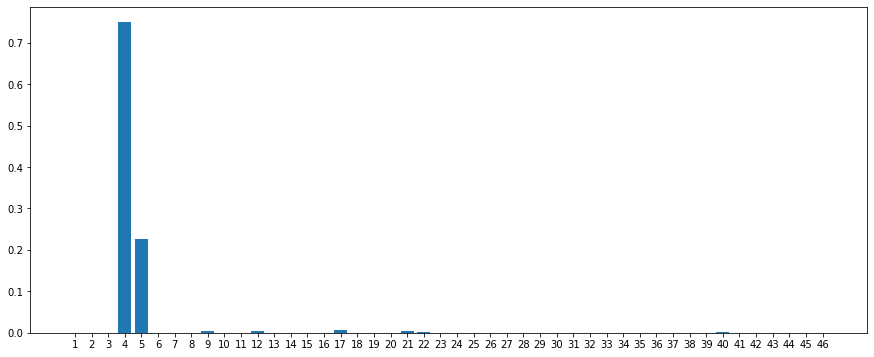

4
1.0000005


array([4.2218853e-05, 1.0499831e-04, 9.3390105e-07, 7.4951380e-01,
       2.2564703e-01, 6.4467051e-05, 1.0180902e-04, 2.8869388e-05,
       3.3915376e-03, 3.5294300e-04, 9.7405391e-05, 3.1823849e-03,
       2.8532249e-04, 9.5372576e-05, 1.5424055e-04, 9.9603429e-05,
       6.8160491e-03, 2.5824792e-04, 2.8987371e-04, 4.7686652e-04,
       3.7659679e-03, 1.6206127e-03, 4.2008236e-05, 3.0211569e-04,
       2.0047384e-05, 7.6424330e-05, 1.3223010e-06, 1.5504668e-04,
       5.1661209e-05, 4.8107939e-04, 3.8017915e-04, 2.4213825e-04,
       1.9383516e-04, 5.7896392e-05, 3.6137430e-05, 1.9590889e-05,
       1.4742742e-04, 4.1024945e-05, 2.8798293e-04, 9.0003340e-04,
       7.4679347e-06, 1.2989844e-04, 3.8638673e-06, 2.7203119e-05,
       9.7139605e-07, 4.6198375e-06], dtype=float32)

In [148]:
prediction = model.predict(x_test)[0]
sujets = np.arange(1,47)

plt.figure(figsize=(15,6))
plt.bar(sujets,prediction)
plt.xticks(sujets)
plt.show()

print(np.argmax(prediction)+1)
print(np.sum(prediction))

### tableau de confusion
Pour évaluer quelles sont les classes les mieux et moins bien prédites une table de confusion est très utiles !

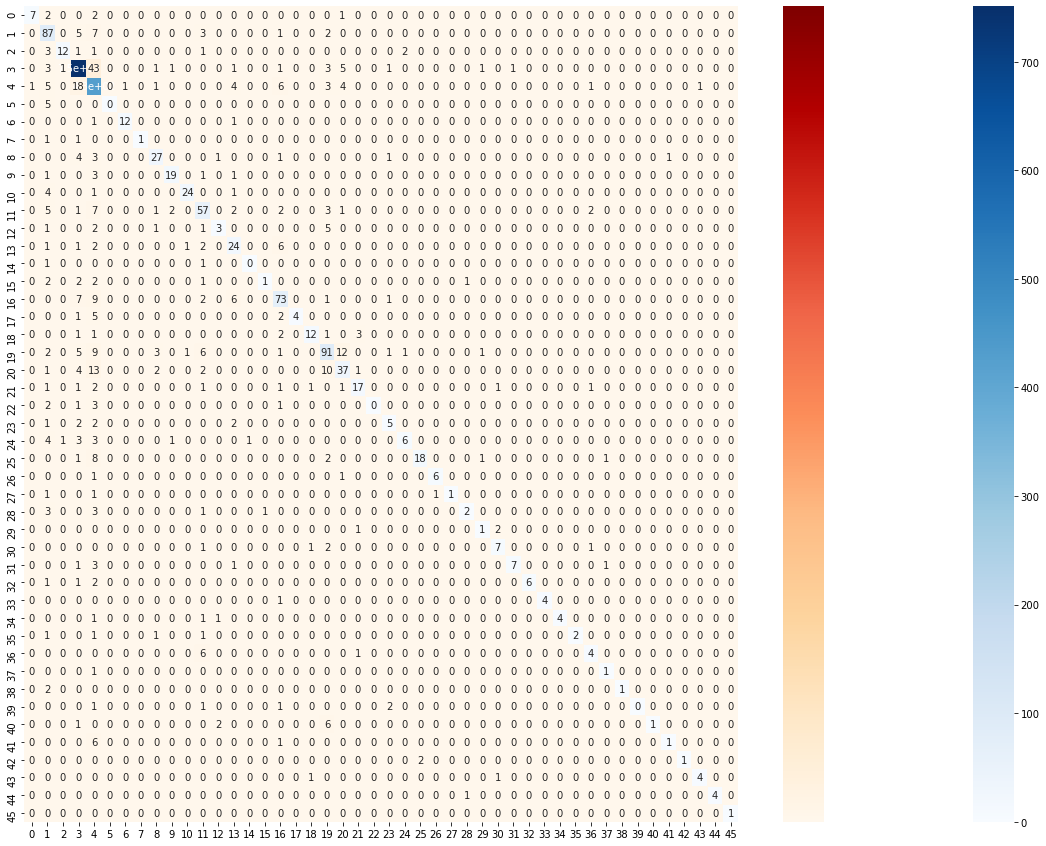

In [220]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = model.predict(x_test).argmax(axis=-1)
cf_matrix = confusion_matrix(y_test,pred)

vmin = np.min(cf_matrix)
vmax = np.max(cf_matrix)
off_diag_mask = np.eye(46, dtype=bool)

fig = plt.figure(figsize=(20,15))
sns.heatmap(cf_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)
sns.heatmap(cf_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))
plt.show()

## Encodage one_hot vs entier

Nous avons précédement les labels en format one hot qui correspont pour chaque observation à un tenseur binaire. Mais il est possible de coder ces étiquette en format entier **CEPENDANT** il faudra changer la fonction de perte dans le réseaux de ```"categorical_crossentropy"``` en ```"sparse_categorical_crossentropy"```. **Par contre** pas possible d'utiliser l'AUC ici... Exemple ici :

In [157]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation="softmax"))

model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",#Here
             metrics = ["accuracy"])

model.fit(x_train,
          y_train,
         epochs = 9,
         batch_size=256,
         validation_data = (x_test,y_test))

Epoch 1/9
36/36 [==============================] - 1s 28ms/step - loss: 2.1001 - accuracy: 0.6112 - val_loss: 1.4550 - val_accuracy: 0.6759
Epoch 2/9
36/36 [==============================] - 1s 16ms/step - loss: 1.1017 - accuracy: 0.7590 - val_loss: 1.1453 - val_accuracy: 0.7422
Epoch 3/9
36/36 [==============================] - 1s 17ms/step - loss: 0.7768 - accuracy: 0.8324 - val_loss: 1.0697 - val_accuracy: 0.7547
Epoch 4/9
36/36 [==============================] - 1s 16ms/step - loss: 0.5622 - accuracy: 0.8783 - val_loss: 0.9894 - val_accuracy: 0.7729
Epoch 5/9
36/36 [==============================] - 1s 17ms/step - loss: 0.4198 - accuracy: 0.9102 - val_loss: 1.1050 - val_accuracy: 0.7453
Epoch 6/9
36/36 [==============================] - 1s 18ms/step - loss: 0.3237 - accuracy: 0.9283 - val_loss: 0.9585 - val_accuracy: 0.7894
Epoch 7/9
36/36 [==============================] - 1s 17ms/step - loss: 0.2627 - accuracy: 0.9393 - val_loss: 0.9803 - val_accuracy: 0.7903
Epoch 8/9
36/36 [===